In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from random import choice
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.decomposition import  PCA
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

In [228]:
df = pd.read_excel('Train_Dataset.xlsx',header=None)
df.head(5)
print(df.info())
df.rename(columns = {560:'Target'}, inplace=True)
print(df['Target'].unique())
df.describe()
df.isnull().any().any()
df.isnull().sum().sum()
new_df = df['Target']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Columns: 561 entries, 0 to 560
dtypes: float64(560), int64(1)
memory usage: 4.3 MB
None
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


## Creating random sample for Subject Train Target - Modified Version

In [229]:
def generate_auth_dataset(df, subj, ratio=3):
        subj_df = df.copy()
        subj_df.loc[(subj_df['Target'] != subj), 'Target'] = 0
        subj_df.loc[(subj_df['Target'] == subj), 'Target'] = 1
        gen_df = subj_df[subj_df['Target'] == 1]
        no_gen = gen_df.shape[0]
        imp_df = subj_df[subj_df['Target'] == 0].sample(n = no_gen * ratio)
        auth_df = pd.concat([gen_df, imp_df])
        return auth_df

In [230]:
df1 = generate_auth_dataset(df,1)

In [231]:
df1['Target'].value_counts()

0    132
1     44
Name: Target, dtype: int64

# Subject 1 Preparation For Train Dataset

## Applying StandardScaler to Dataset

In [232]:
scaler = StandardScaler()
X_Feat, y_train = df1.iloc[:, :-1].values, df1.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data = scaler.transform(X_Feat)

## Feature Reductionality -  PCA 

In [233]:
pca = PCA(n_components=30)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
x_pca.shape

(176, 30)

# Loading Dataset for Subject 1 Testing

In [234]:
df_test = pd.read_excel('Test_Dataset.xlsx',header=None)
df_test.rename(columns = {560:'Target'}, inplace=True)


In [235]:
df1_test = generate_auth_dataset(df_test, 1, ratio=3)

In [236]:
df1_test['Target'].unique()

array([1, 0], dtype=int64)

In [237]:
df1_test['Target'].value_counts()

0    72
1    24
Name: Target, dtype: int64

## Applying StandardScaler to Dataset

In [238]:
scaler = StandardScaler()
X_Feat_test, y_test = df1_test.iloc[:, :-1].values, df1_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test = scaler.transform(X_Feat_test)

# Feature Reductionality -  PCA 

In [239]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test)
x_pca_test = pca.transform(scaled_data_test)
x_pca_test.shape

(96, 30)

# Machine Learning Application

## Assigning Train and test Labels to Loaded Dataset

In [240]:
X_test = x_pca_test
X_train = x_pca

In [241]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[71  1]
 [24  0]]


              precision    recall  f1-score   support

           0       0.75      0.99      0.85        72
           1       0.00      0.00      0.00        24

    accuracy                           0.74        96
   macro avg       0.37      0.49      0.43        96
weighted avg       0.56      0.74      0.64        96



In [242]:
score_test = accuracy_score(y_test,predictions)
score_test

0.7395833333333334

In [243]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# SVC best estimator
# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
#print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

In [244]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

svc = grid_svc.best_estimator_

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

In [245]:
from sklearn.metrics import roc_auc_score

print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))

Support Vector Classifier:  0.8362603305785125


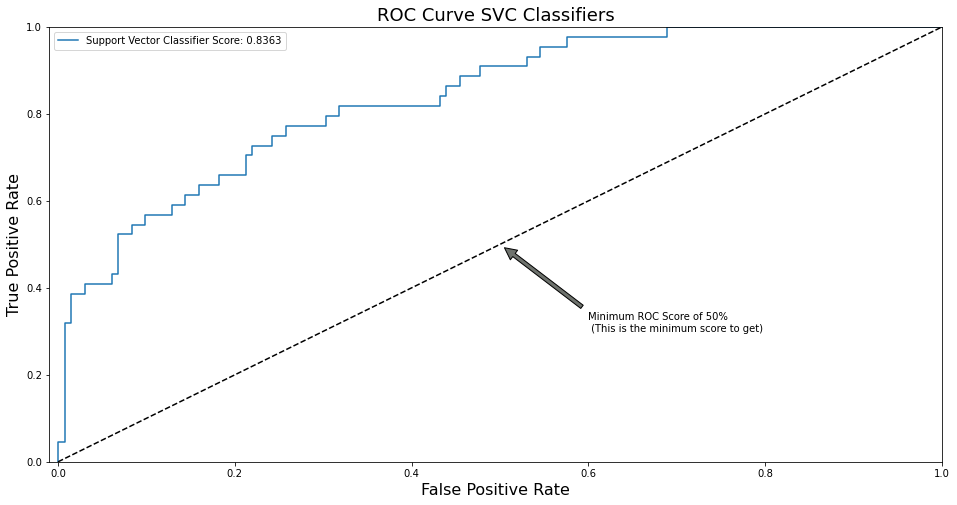

In [246]:
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)

def graph_roc_curve_multiple(svc_fpr, svc_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve SVC Classifiers', fontsize=18)
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(svc_fpr, svc_tpr)
plt.show()

# Subject 2

df2 = generate_auth_dataset(df,1)
df2_test = generate_auth_dataset(df,1)